In [1]:
import os
import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

In [2]:
DATA_DIR = '../dataset'
SUBMISSION_DIR = '../submission'

In [3]:
df_history = pd.read_csv(os.path.join(DATA_DIR, 'history_data.csv'))
df_watch = pd.read_csv(os.path.join(DATA_DIR, 'watch_e_data.csv'))
df_profile = pd.read_csv(os.path.join(DATA_DIR, 'profile_data.csv'))
df_meta = pd.read_csv(os.path.join(DATA_DIR, 'meta_data.csv'))

/tmp/ipykernel_4567/4180386698.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(os.path.join(DATA_DIR, 'meta_data.csv'))


## History Processing

In [4]:
df_history['continuous_play'] = np.where(df_history['continuous_play']=='Y', 1, 0)
df_history['short_trailer'] = np.where(df_history['short_trailer']=='Y', 1, 0)
df_history['ss_continuous_cnt'] = df_history.groupby(['profile_id', 'ss_id'])['continuous_play'].transform('cumsum')

## Watch Processing

In [5]:
df_watch['watch_ratio'] = df_watch['watch_time'] / df_watch['total_time']
df_watch['ss_watch_cnt'] = df_watch.groupby(['profile_id', 'ss_id', 'album_id'])['act_target_dtl'].transform('cumcount') + 1
df_watch_real = df_watch.query('watch_ratio>=0.1').reset_index(drop=True)

## Merge DataFrames

In [6]:
df_seen = pd.merge(df_history.drop('log_time', axis=1),
                   df_watch_real.drop('log_time', axis=1),
                   how='inner',
                   on=['profile_id', 'ss_id', 'album_id'])

In [7]:
df_cleansing = df_seen.drop_duplicates(subset=['profile_id', 'ss_id', 'album_id'], keep='last').reset_index(drop=True)

In [8]:
# df_cleansing = pd.concat([df_seen.drop_duplicates(subset=['profile_id', 'ss_id', 'album_id'], keep='first'),
#                           df_seen.drop_duplicates(subset=['profile_id', 'ss_id', 'album_id'], keep='last')]
#                         )

# df_cleansing = df_cleansing.drop_duplicates(subset=['profile_id', 'ss_id', 'album_id', 'ss_continuous_cnt'], keep='first')
# df_cleansing = df_cleansing.sort_values(by=['profile_id', 'ss_id', 'ss_continuous_cnt']).reset_index(drop=True)

In [9]:
df_meta['genre_mid'] = np.where(df_meta['genre_mid']=="노래 율동", '노래율동', df_meta['genre_mid'])

In [10]:
df_cleansing = df_cleansing.merge(df_meta[['album_id', 'genre_large', 'genre_mid']].drop_duplicates(),
                                  how='left',
                                  on='album_id'
                                  )

In [11]:
df_cleansing.shape

(484163, 16)

### Genre Mid Nunique Count in Session

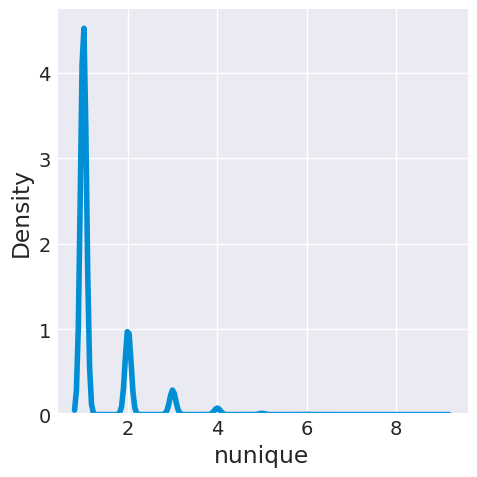

In [12]:
(df_cleansing
 .groupby(['profile_id', 'ss_id'])['genre_mid']
 .agg(['count', 'nunique'])
 .reset_index()
 .pipe((sns.displot, 'data'),
       x='nunique',
       kind='kde'
       )
)

## Get Preference Index By Album

In [13]:
album_stat = (df_cleansing
              .groupby('album_id')
              .agg({'profile_id': ['nunique'], 
                    'ss_id': ['nunique'], 
                    'ss_watch_cnt':['sum']})
              .reset_index()
              .droplevel(1, axis=1)
              )

In [14]:
album_stat['preference_index'] = (album_stat['ss_watch_cnt'] / album_stat['ss_id']) * album_stat['profile_id']

In [15]:
album_stat = album_stat.merge(df_meta.filter(['album_id', 'genre_large', 'genre_mid']).drop_duplicates(),
                              how='left',
                              on='album_id')
album_stat.head()

,album_id,profile_id,ss_id,ss_watch_cnt,preference_index,genre_large,genre_mid
0,0,490,621,771,608.357488,키즈,외국어
1,1,117,134,177,154.544776,키즈,외국어
2,2,90,109,165,136.238532,키즈,외국어
3,3,86,114,162,122.210526,키즈,외국어
4,4,105,149,178,125.436242,키즈,TV만화


In [16]:
album_genre_dict = {k:v for k, v in zip(df_meta.album_id, df_meta.genre_mid)}

In [17]:
genre_rec = (album_stat
             .groupby('genre_mid')[['preference_index', 'album_id']]
             .apply(lambda x: x.nlargest(25, columns=['preference_index']))
             .reset_index()
             .groupby('genre_mid')['album_id']
             .apply(list)
)

In [22]:
genre_rec

genre_mid
MCN       [2056, 2159, 3624, 4916, 604, 9758, 17317, 180...
TV만화      [416, 2054, 264, 737, 419, 309, 2082, 740, 417...
극장판 애니            [6392, 444, 3460, 2329, 2328, 3996, 2343]
노래율동      [16, 19, 15, 18, 17, 38, 3502, 224, 39, 225, 3...
놀이교실      [2298, 624, 625, 1329, 2299, 2736, 4608, 5, 88...
다큐멘터리     [6725, 2918, 5711, 3040, 7295, 8839, 6726, 571...
독서동화      [311, 2183, 2182, 7676, 1607, 7438, 4069, 1567...
드라마       [1982, 1983, 7252, 2338, 12533, 10880, 10983, ...
수학과학      [6350, 5702, 6359, 6351, 6587, 6375, 6313, 658...
시리즈       [525, 350, 349, 2081, 452, 487, 521, 467, 510,...
시사교양      [11559, 11252, 9839, 16274, 22980, 23840, 2384...
애니        [1868, 332, 313, 1984, 3768, 1985, 6125, 6012,...
액션/모험     [2112, 466, 464, 468, 368, 465, 707, 366, 734,...
어린이방송     [2341, 5688, 524, 2920, 61, 3015, 4648, 8745, ...
역사/문화                               [382, 3014, 7090, 6577]
연예오락                                                [19471]
예능        [2185, 2889, 3653, 1

In [23]:
import gc

def get_pair_topk(df, k):
    documents = df.groupby(['profile_id', 'ss_id'])['album_id'].agg(list).rename('pair').reset_index()
    df_pair = df[['profile_id', 'ss_id', 'album_id']].merge(documents, on=['profile_id', 'ss_id'], how='left')
    
    del df, documents
    gc.collect()
    
    df_pair = df_pair[['album_id', 'pair']].explode(column='pair')
    df_pair = df_pair.loc[df_pair['album_id']!=df_pair['pair']].reset_index(drop=True)
    
    df_pair = df_pair.groupby(['album_id', 'pair']).size().rename('count').reset_index()
    df_pair = df_pair.sort_values(['album_id' ,'count'], ascending=False).reset_index(drop=True)
    
    df_pair['rank'] = df_pair.groupby('album_id')['pair'].cumcount()
    df_pair = df_pair.loc[df_pair['rank']<=k].reset_index(drop=True)
    df_pair = df_pair.sort_values(by=['album_id', 'rank']).reset_index(drop=True)
    return df_pair

In [24]:
df_pair = get_pair_topk(df_watch_real, k=2)

In [25]:
df_pair.head()

,album_id,pair,count,rank
0,0,229,183,0
1,0,15,179,1
2,0,347,169,2
3,1,2,148,0
4,1,3994,133,1


# ALL

In [26]:
df_cleansing = df_cleansing.merge(df_profile[['profile_id', 'sex', 'age']], 
                                  how='left',
                                  on=['profile_id'])

In [27]:
group_rec = (df_cleansing
             .groupby(['sex', 'age', 'album_id'])['ss_watch_cnt'].sum()
             .reset_index(name='group_watch_sum')
             .groupby(['sex', 'age'])[['group_watch_sum', 'album_id']].apply(lambda x: x.nlargest(25, columns=['group_watch_sum']))
             .reset_index()
             .groupby(['sex','age'])['album_id'].apply(list)
             .reset_index(name='pred_list')
            )

In [36]:
re_watch = (df_cleansing
            .groupby(['profile_id', 'album_id'])['ss_watch_cnt'].sum()
            .reset_index(name='profile_watch_sum')
            .groupby('profile_id')[['profile_watch_sum', 'album_id']].apply(lambda x: x.nlargest(25, columns=['profile_watch_sum']))
            .reset_index()
            .groupby('profile_id')['album_id'].apply(list)
            .reset_index(name='predicted_list')
           )

In [37]:
# pair_dict = dict(zip(df_pair.album_id, df_pair.pair))
pair_dict = df_pair.groupby('album_id')['pair'].apply(list)

In [38]:
def rec_with_pair(arr, k, pair_rec):
    n = len(arr)
    init = len(arr)
    start = 0 
    while n<k and start<init:
        if arr[start] in pair_rec.keys():
            for i in pair_rec[arr[start]]:
                if n<k and i not in arr:
                    arr.append(i)
                    n+=1
                else:
                    break
            start+=1
        else:
            start+=1
    return arr

In [39]:
# re_watch['predicted_list'] = list(np.vectorize(rec_pair)(re_watch['predicted_list'], 25, pair_dict))
re_watch['predicted_list'] = re_watch['predicted_list'].map(lambda x: rec_with_pair(x, 25, pair_dict))

In [40]:
def rec_with_genre(arr, k, genre_dict, genre_rec):
    n = len(arr)
    start = 0
    while n<k:
        prefer_genre = genre_dict[arr[start]]
        for i in genre_rec[prefer_genre]:
            if i not in arr:
                arr.append(i)
                n+=1
            else:
                continue
        start+=1
    return arr

In [41]:
re_watch['predicted_list'] = re_watch['predicted_list'].map(lambda x: rec_with_genre(x, 25, album_genre_dict, genre_rec))

In [42]:
re_watch.head(10)

,profile_id,predicted_list
0,3,"[20, 15, 25, 31, 30, 29, 28, 27, 26, 24, 16, 2..."
1,5,"[84, 128, 314, 317, 86, 74, 75, 15, 72, 73, 90..."
2,7,"[237, 343, 2436, 417, 1006, 225, 241, 38, 416,..."
3,19,"[403, 404, 2567, 5172, 16, 19, 15, 18, 17, 38,..."
4,20,"[442, 478, 491, 426, 471, 479, 430, 356, 476, ..."
5,22,"[593, 799, 835, 302, 291, 1002, 655, 1000, 16,..."
6,24,"[1869, 339, 2861, 537, 124, 125, 65, 241, 190,..."
7,27,"[124, 50, 801, 1886, 1884, 1883, 1882, 1881, 1..."
8,30,"[1915, 1919, 150, 225, 232, 1916, 1917, 1918, ..."
9,31,"[1949, 1944, 1946, 1950, 1951, 1953, 1930, 193..."


In [55]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), usecols=['profile_id'])

In [56]:
sub = sub.merge(df_profile[['profile_id', 'sex', 'age']], 
                how='left',
                on=['profile_id'])

In [47]:
sub = sub.merge(re_watch, how='left', on=['profile_id'])
sub['predicted_list'] = sub['predicted_list'].apply(lambda d: d if isinstance(d, list) else [])

In [57]:
# sub = sub.merge(group_rec, how='left', on=['sex', 'age', 'interest_keyword_cd'])
sub = sub.merge(group_rec, how='left', on=['sex', 'age'])

In [58]:
sub.head()

,profile_id,sex,age,pred_list
0,3,F,5,"[124, 125, 65, 190, 339, 188, 329, 16, 15, 126..."
1,5,M,5,"[16, 124, 15, 125, 19, 65, 339, 18, 17, 38, 24..."
2,7,F,9,"[125, 65, 124, 241, 127, 2472, 190, 347, 339, ..."
3,12,M,6,"[124, 19, 16, 65, 126, 125, 424, 18, 339, 190,..."
4,16,F,12,"[38, 39, 225, 136, 230, 40, 41, 42, 43, 44, 45..."


In [ ]:
sub[['profile_id', 'pred_list']].rename(columns={'pred_list':'predicted_list'}).to_csv(os.path.join(SUBMISSION_DIR, 'baseline_group.csv'), index=False, encoding='utf-8-sig')

In [49]:
# sub['pred_list_x'] = sub['pred_list_x'].apply(lambda d: d if isinstance(d, list) else [])

In [50]:
sub['a'] = sub['predicted_list'] + sub['pred_list']

In [51]:
sub['a'] = sub['a'].map(lambda x: x[:25])

In [52]:
sub[['profile_id', 'a']].rename(columns={'a':'predicted_list'}).to_csv(os.path.join(SUBMISSION_DIR, 'baseline_rec5.csv'), index=False, encoding='utf-8-sig')